In [1]:
import json
import os
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix)
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms
from tqdm import tqdm

# --- 1. 설정 (Configuration) ---
CONFIG = {
    "image_dir": "sleepy/dataset/Trainning/image_trainning/all_image_trainning",
    "label_dir": "sleepy/dataset/Trainning/label_trainning/all_label_trainning",
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    "img_size": 90,
    "batch_size": 32,
    "epochs": 15,
    "learning_rate": 0.001,
    "max_samples": 9000,  # None으로 설정하면 모든 데이터를 사용합니다.
    "model_path": "eye_state_classifier.pth"
}


# --- 2. 유틸리티 함수 (Utility Functions) ---
def str2bool(val: str) -> bool:
    """문자열을 boolean 값으로 변환합니다."""
    return str(val).lower() in ("true", "1")

def crop_and_resize_eye(frame: np.ndarray, bbox: tuple, size: int = 90) -> np.ndarray | None:
    """
    주어진 바운딩 박스를 이용해 이미지를 크롭하고 리사이즈합니다.

    Args:
        frame (np.ndarray): 원본 이미지 프레임.
        bbox (tuple): (x, y, w, h) 형태의 바운딩 박스.
        size (int): 리사이즈할 이미지의 크기.

    Returns:
        np.ndarray | None: 처리된 이미지 또는 실패 시 None.
    """
    if bbox is None:
        return None
    
    x, y, w, h = bbox
    # BBox에 여유 공간(padding)을 추가하여 눈 주변 영역을 더 많이 포함시킵니다.
    x1 = max(x - int(w * 0.5), 0)
    y1 = max(y - int(h * 0.5), 0)
    x2 = min(x + w + int(w * 0.5), frame.shape[1])
    y2 = min(y + h + int(h * 0.5), frame.shape[0])

    eye_crop = frame[y1:y2, x1:x2]

    if eye_crop.size == 0:
        return None
        
    return cv2.resize(eye_crop, (size, size))


# --- 3. 데이터셋 클래스 (Dataset Class) ---
class EyeDataset(Dataset):
    """
    눈 이미지와 상태(Opened/Closed) 레이블을 로드하는 커스텀 데이터셋 클래스.
    메모리 효율성을 위해 이미지 경와 정보만 저장하고, __getitem__에서 이미지를 로드합니다.
    """
    def __init__(self, image_dir: str, label_dir: str, transform=None, max_samples: int | None = None):
        self.image_dir = Path(image_dir)
        self.label_dir = Path(label_dir)
        self.transform = transform
        self.samples = []

        image_files = sorted([f for f in os.listdir(image_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
        if max_samples:
            image_files = image_files[:max_samples]

        print("🔍 데이터셋을 스캔하고 유효한 샘플을 수집합니다...")
        for img_name in tqdm(image_files, desc="데이터셋 로딩 중"):
            img_path = self.image_dir / img_name
            label_path = self.label_dir / (img_name.rsplit('.', 1)[0] + '.json')

            if not label_path.exists():
                continue

            try:
                with open(label_path, 'r', encoding='utf-8') as f:
                    label_data = json.load(f)
            except Exception:
                continue

            object_info = label_data.get('ObjectInfo', {})
            keypoints_info = object_info.get('KeyPoints', {})
            points = keypoints_info.get('Points')
            bounding_boxes = object_info.get('BoundingBox', {})

            if not points or len(points) < (47 * 2):
                continue
            
            try:
                points_arr = np.array(points, dtype=np.float32).reshape(-1, 2)
            except (ValueError, TypeError):
                continue

            leye_indices = [36, 37, 38, 39, 40, 41]
            reye_indices = [42, 43, 44, 45, 46, 47]

            leye_points = points_arr[leye_indices]
            reye_points = points_arr[reye_indices]

            lx_min, ly_min = np.min(leye_points, axis=0)
            lx_max, ly_max = np.max(leye_points, axis=0)
            rx_min, ry_min = np.min(reye_points, axis=0)
            rx_max, ry_max = np.max(reye_points, axis=0)

            leye_bbox = (int(lx_min), int(ly_min), int(lx_max - lx_min), int(ly_max - ly_min))
            reye_bbox = (int(rx_min), int(ry_min), int(rx_max - rx_min), int(ry_max - ry_min))

            leye_opened = str2bool(bounding_boxes.get('Leye', {}).get('Opened', False))
            reye_opened = str2bool(bounding_boxes.get('Reye', {}).get('Opened', False))

            # 유효한 눈 데이터만 샘플에 추가
            if leye_bbox[2] > 0 and leye_bbox[3] > 0:
                self.samples.append((str(img_path), leye_bbox, int(leye_opened)))
            if reye_bbox[2] > 0 and reye_bbox[3] > 0:
                self.samples.append((str(img_path), reye_bbox, int(reye_opened)))

        print(f"✅ 총 {len(self.samples)}개의 유효한 눈 데이터를 수집했습니다.")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, bbox, label = self.samples[idx]
        
        # 이미지를 필요할 때 로드 (Lazy Loading)
        image_cv = cv2.imread(img_path)
        if image_cv is None:
            # 이미지 로드 실패 시, 다음 샘플을 시도하거나 에러 처리
            # 여기서는 간단히 None을 반환하고 DataLoader에서 처리하도록 함
            return None, None

        eye_img = crop_and_resize_eye(image_cv, bbox, size=CONFIG['img_size'])
        if eye_img is None:
            return None, None

        # OpenCV(BGR) 이미지를 PIL(RGB)로 변환
        image_pil = Image.fromarray(cv2.cvtColor(eye_img, cv2.COLOR_BGR2RGB))

        if self.transform:
            image = self.transform(image_pil)
        
        return image, torch.tensor(label, dtype=torch.float)


# --- 4. 모델 아키텍처 (Model Architecture) ---
class EyeCNN(nn.Module):
    """눈 상태 분류를 위한 간단한 CNN 모델."""
    def __init__(self):
        super(EyeCNN, self).__init__()
        img_size = CONFIG['img_size']
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        
        # 3번의 Max Pooling 후의 피처맵 크기 계산
        # 90x90 -> Pool -> 45x45 -> Pool -> 22x22 -> Pool -> 11x11
        final_size = img_size // (2**3)
        
        self.fc1 = nn.Linear(128 * final_size * final_size, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 1)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        x = x.view(x.size(0), -1) # Flatten
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc3(x))
        return x


# --- 5. 학습 및 평가 함수 (Train & Evaluate Functions) ---
def train_model(model, train_loader, criterion, optimizer, device, epochs):
    """모델 학습을 위한 함수"""
    model.train()
    train_losses = []
    print("\n=== 🚀 학습 시작 ===")
    for epoch in range(epochs):
        running_loss = 0.0
        # tqdm을 사용하여 진행률 표시
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1:02d}/{epochs}"):
            if images is None: continue

            images = images.to(device)
            labels = labels.float().unsqueeze(1).to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        avg_loss = running_loss / len(train_loader)
        train_losses.append(avg_loss)
        print(f"Epoch [{epoch+1:02d}/{epochs}], Loss: {avg_loss:.4f}")
    
    print("=== ✅ 학습 종료 ===")
    return train_losses



💡 사용 디바이스: cuda
🔍 데이터셋을 스캔하고 유효한 샘플을 수집합니다...


데이터셋 로딩 중: 100%|██████████| 9000/9000 [00:01<00:00, 4613.33it/s]


✅ 총 17990개의 유효한 눈 데이터를 수집했습니다.

학습 데이터셋 크기: 14392
테스트 데이터셋 크기: 3598

EyeCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=15488, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

=== 🚀 학습 시작 ===


Epoch 01/15: 100%|██████████| 450/450 [01:06<00:00,  6.74it/s]


Epoch [01/15], Loss: 0.0031


Epoch 02/15: 100%|██████████| 450/450 [01:12<00:00,  6.17it/s]


Epoch [02/15], Loss: 0.0000


Epoch 03/15: 100%|██████████| 450/450 [01:05<00:00,  6.85it/s]


Epoch [03/15], Loss: 0.0000


Epoch 04/15: 100%|██████████| 450/450 [01:08<00:00,  6.61it/s]


Epoch [04/15], Loss: 0.0000


Epoch 05/15: 100%|██████████| 450/450 [01:07<00:00,  6.70it/s]


Epoch [05/15], Loss: 0.0000


Epoch 06/15: 100%|██████████| 450/450 [01:05<00:00,  6.89it/s]


Epoch [06/15], Loss: 0.0000


Epoch 07/15: 100%|██████████| 450/450 [01:04<00:00,  6.99it/s]


Epoch [07/15], Loss: 0.0000


Epoch 08/15: 100%|██████████| 450/450 [01:05<00:00,  6.91it/s]


Epoch [08/15], Loss: 0.0000


Epoch 09/15: 100%|██████████| 450/450 [01:08<00:00,  6.59it/s]


Epoch [09/15], Loss: 0.0000


Epoch 10/15: 100%|██████████| 450/450 [01:10<00:00,  6.42it/s]


Epoch [10/15], Loss: 0.0000


Epoch 11/15: 100%|██████████| 450/450 [01:11<00:00,  6.34it/s]


Epoch [11/15], Loss: 0.0000


Epoch 12/15: 100%|██████████| 450/450 [01:11<00:00,  6.33it/s]


Epoch [12/15], Loss: 0.0000


Epoch 13/15: 100%|██████████| 450/450 [01:13<00:00,  6.16it/s]


Epoch [13/15], Loss: 0.0000


Epoch 14/15: 100%|██████████| 450/450 [01:10<00:00,  6.41it/s]


Epoch [14/15], Loss: 0.0000


Epoch 15/15: 100%|██████████| 450/450 [01:10<00:00,  6.38it/s]


Epoch [15/15], Loss: 0.0000
=== ✅ 학습 종료 ===

=== 📊 모델 평가 시작 ===


평가 중: 100%|██████████| 113/113 [00:16<00:00,  7.01it/s]



[디버깅 정보]
y_true 클래스 분포: {np.float32(0.0): np.int64(3598)}
y_pred 클래스 분포: {np.int32(0): np.int64(3598)}

[평가 결과]
              precision    recall  f1-score   support

  Closed (0)       1.00      1.00      1.00      3598
  Opened (1)       0.00      0.00      0.00         0

    accuracy                           1.00      3598
   macro avg       0.50      0.50      0.50      3598
weighted avg       1.00      1.00      1.00      3598

Confusion Matrix:
[[3598    0]
 [   0    0]]

Accuracy: 1.0000

💾 학습된 모델을 'eye_state_classifier.pth'에 저장했습니다.


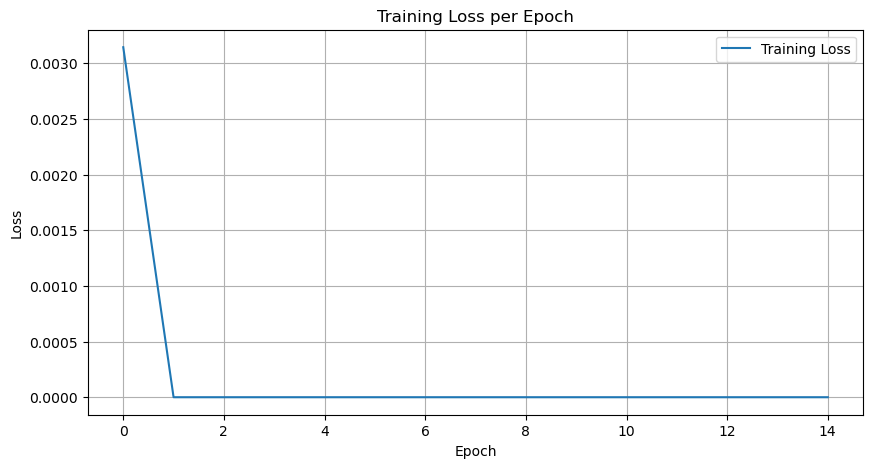

In [2]:
def evaluate_model(model, test_loader, device):
    """학습된 모델을 평가하는 함수"""
    model.eval()
    all_preds = []
    all_labels = []
    
    print("\n=== 📊 모델 평가 시작 ===")
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="평가 중"):
            if images is None: continue

            images = images.to(device)
            outputs = model(images)
            predicted = (outputs > 0.5).int().cpu().squeeze()
            
            all_preds.append(predicted)
            all_labels.append(labels)

    # 리스트에 있는 텐서들을 하나로 합침
    y_pred = torch.cat([p.view(-1) for p in all_preds]).numpy()
    y_true = torch.cat([l.view(-1) for l in all_labels]).numpy()

    # 클래스 분포 확인
    unique_true, counts_true = np.unique(y_true, return_counts=True)
    unique_pred, counts_pred = np.unique(y_pred, return_counts=True)

    print("\n[디버깅 정보]")
    print(f"y_true 클래스 분포: {dict(zip(unique_true, counts_true))}")
    print(f"y_pred 클래스 분포: {dict(zip(unique_pred, counts_pred))}")
    
    print("\n[평가 결과]")
    print(classification_report(y_true, y_pred, target_names=['Closed (0)', 'Opened (1)'], labels=[0, 1], zero_division=0))
    
    print("Confusion Matrix:")
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    print(cm)
    
    print(f"\nAccuracy: {accuracy_score(y_true, y_pred):.4f}")


# --- 6. 메인 실행 블록 (Main Execution Block) ---
if __name__ == "__main__":
    print(f"💡 사용 디바이스: {CONFIG['device']}")

    # 데이터셋 및 데이터로더 준비
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    
    full_dataset = EyeDataset(
        CONFIG['image_dir'], 
        CONFIG['label_dir'], 
        transform=transform, 
        max_samples=CONFIG['max_samples']
    )

    if len(full_dataset) > 0:
        # DataLoader에서 None 값을 걸러내기 위한 collate_fn
        def collate_fn(batch):
            batch = list(filter(lambda x: x[0] is not None, batch))
            if not batch: return torch.Tensor(), torch.Tensor()
            return torch.utils.data.dataloader.default_collate(batch)

        # 데이터셋 분할 (학습: 80%, 테스트: 20%)
        train_size = int(0.8 * len(full_dataset))
        test_size = len(full_dataset) - train_size
        train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

        train_loader = DataLoader(train_dataset, batch_size=CONFIG['batch_size'], shuffle=True, collate_fn=collate_fn)
        test_loader = DataLoader(test_dataset, batch_size=CONFIG['batch_size'], shuffle=False, collate_fn=collate_fn)

        print(f"\n학습 데이터셋 크기: {len(train_dataset)}")
        print(f"테스트 데이터셋 크기: {len(test_dataset)}\n")

        # 모델, 손실 함수, 옵티마이저 정의
        model = EyeCNN().to(CONFIG['device'])
        print(model)
        
        criterion = nn.BCELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=CONFIG['learning_rate'])
        
        # 모델 학습
        train_losses = train_model(model, train_loader, criterion, optimizer, CONFIG['device'], CONFIG['epochs'])
        
        # 모델 평가
        if len(test_loader.dataset) > 0:
            evaluate_model(model, test_loader, CONFIG['device'])
        
        # 모델 가중치 저장
        torch.save(model.state_dict(), CONFIG['model_path'])
        print(f"\n💾 학습된 모델을 '{CONFIG['model_path']}'에 저장했습니다.")

        # 손실 그래프 시각화
        plt.figure(figsize=(10, 5))
        plt.plot(train_losses, label='Training Loss')
        plt.title("Training Loss per Epoch")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid(True)
        plt.show()

    else:
        print("❌ 학습할 데이터가 없습니다. 데이터셋 경로와 내용을 확인해주세요.")